In this section, we are going to preprocess and analyze text. Our task is multiclass classification prblem predicting multiple price buckets, separately for properties that are for rent or for sale. The preprocessing will be implemented on the whole dataset from the start, as it has nothing to do with the classification, and our text analysis will first be implemented on the whole dataset and then separately on each case (rent properties, sale properties) to explore the differeces among the three sets (whole df, rent df, sale df).

In [1]:
! pip install pyspark seaborn

In [2]:
! pip install beautifulsoup4


In [4]:

import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])


0

In [5]:
! pip install wordcloud

In [6]:
# libraries

import sklearn
import pandas as pd
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
import string
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import NGram, CountVectorizer, IDF, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import Row
import numpy as np
from wordcloud import WordCloud
from pyspark.sql import functions as F # to use F in the code
from pyspark.ml.clustering import LDA


In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Read Dataset

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/Colab Notebooks/Project/"

Mounted at /content/gdrive


In [5]:
# create Spark Session
spark = SparkSession.builder.appName("Project511").master("local[*]").getOrCreate()



Read the dataset which has been preprocessed.

In [6]:
df = spark.read.format("parquet").load(google_drive_path + "ar_properties_processed.parquet")

In [7]:
df.count()

259910

In [8]:
df.show()

+----------+----------+--------------------+-------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+
|start_date|  end_date|                  l2|     l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|               title|         description|property_type|operation_type|         coordinates|   amount_in_euro|
+----------+----------+--------------------+-------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+
|2020-11-02|2020-11-16|Bs.As. G.B.A. Zon...|  Tigre|    2|       2|        1|        550.0|          267.0|Venta lote Las Ti...|Lote interno en z...|          Lot|          Sale|[-34.406894683837...|         154700.0|
|2020-11-02|9999-12-31|            Santa Fe| Alvear|    2|       2|        1|       438.17|         347.07|Vendo lote de 268...|

In [9]:
df.columns

['start_date',
 'end_date',
 'l2',
 'l3',
 'rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'title',
 'description',
 'property_type',
 'operation_type',
 'coordinates',
 'amount_in_euro']

# NLP

In [ ]:
df.groupBy("property_type").count().show()

+----------------+-----+
|   property_type|count|
+----------------+-----+
|Commercial Space| 8979|
|       Apartment|96897|
|          Office| 7048|
|             Lot|22124|
|   Country House|  347|
|           Other|63958|
|          Garage| 2377|
|       Warehouse| 1715|
|           House|46962|
|          Duplex| 9503|
+----------------+-----+



In [ ]:
df.groupBy("operation_type").count().show()

+--------------+------+
|operation_type| count|
+--------------+------+
|          Rent| 49569|
|          Sale|210341|
+--------------+------+



## Translation

In our fist trial, we translated the dataset to english, but both the transformers that we tried had some flaws and couldnt translate the dataset efficiently.

MarianMT transformer, replicated a lot of words and additionally, it couldnt capture all the words in english.

So, we decided to continue with our spanish dataset, and later on we will translate manually the most important words (wordclouds).

Rergarding columns operate_type and property_type have been already been translated manually for better management of the project and better interpretability.

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# !pip install sacremoses
# !pip install transformers

### MarianMTModel, Marian Tokenizer

In [ ]:
# from transformers import MarianMTModel, MarianTokenizer

In [ ]:
# # load model and tokenizer
# model_name = 'Helsinki-NLP/opus-mt-es-en'
# tokenizer = MarianTokenizer.from_pretrained(model_name)
# model = MarianMTModel.from_pretrained(model_name)

# @pandas_udf("string")
# def translate_text(batch: pd.Series) -> pd.Series:
#     inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=512)
#     outputs = model.generate(**inputs)
#     translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in outputs]
#     return pd.Series(translated_texts)




debugging

In [ ]:
# pd.set_option('display.max_colwidth', None)
# # @pandas_udf("string")
# def translate_text_local(batch):
#     print("******")
#     print("Batch Input:", batch.tolist())  # Debug input
#     lista = batch.tolist()
#     for item in lista:
#       print(item)
#     inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=512)
#     outputs = model.generate(**inputs)
#     translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in outputs]
#     print("Translated Output:", translated_texts)  # Debug output
#     for item in translated_texts:
#       print(item)
#     return pd.Series(translated_texts)

### MBart

In [ ]:
# from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# model_name = 'facebook/mbart-large-50-many-to-many-mmt'
# tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
# model = MBartForConditionalGeneration.from_pretrained(model_name)
# tokenizer.src_lang = "es_XX"
# tokenizer.tgt_lang = "en_XX"


In [ ]:
# @pandas_udf("string")
# def translate_text(batch: pd.Series) -> pd.Series:
#     inputs = tokenizer(list(batch), return_tensors="pt", padding=True, truncation=True, max_length=512)
#     outputs = model.generate(**inputs)
#     translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in outputs]
#     return pd.Series(translated_texts)

**EXPLANATION OF THE CODE**

SCALAR with a direct type hint in the @pandas_udf("string") decorator, which specifies that the UDF returns a series of strings. The function definition includes the types for input and output explicitly (batch: pd.Series -> pd.Series).
DataFrame Transformation: We apply each transformation on the updated DataFrame to ensure that all transformations are carried through.

In [ ]:

# spark_filled = spark_filled.withColumn("translated_title", translate_text("title"))
# spark_filled = spark_filled.withColumn("translated_description", translate_text("description"))
# spark_filled = spark_filled.withColumn("translated_op_type", translate_text("operation_type"))
# spark_filled = spark_filled.withColumn("translated_property_type", translate_text("property_type"))

In [ ]:
# spark_filled.show()

## Text Preprocessing

### Translated Dataset

In [ ]:
# from IPython.display import clear_output

# ! pip install twokenize nltk ekphrasis

# import re, string, nltk, itertools
# from nltk.corpus import stopwords
# nltk.download("stopwords")

# # lemmatization
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# from nltk.stem import WordNetLemmatizer

# # stemming
# from nltk.stem import PorterStemmer

# #tokenization
# import twokenize

# # hashtags handling
# from ekphrasis.classes.segmenter import Segmenter

# # sentiment analysis
# from textblob import TextBlob

# from pyspark.sql.functions import *
# from pyspark.sql.types import *
# import string

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# clear_output()

In [ ]:
# from pyspark.sql.functions import col, size, split

# in order to count how many words we have totally before preprocessing

# # add a new column to the DataFrame that counts the words in the description
# df_with_word_count = spark_filled.withColumn("word_count", size(split(col("description"), "\\s+")))
# # df_with_word_count = df_with_word_count.withColumn("word_count_translated", size(split(col("translated_description"), "\\s+")))

# df_with_word_count.select("description", "word_count").show(truncate=False)

# df_with_word_count.agg(sum("word_count")).show()
# # df_with_word_count.agg(sum("word_count_translated")).show()

In [ ]:
# def remove_html_tags(text):
#     # regex to identify HTML tags
#     clean_text = re.sub(r'<.*?>', '', text)
#     return clean_text

In [ ]:
# def uncontract(text):
#     text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
#     text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
#     text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
#     text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)

#     text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
#     text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
#     text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
#     text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
#     text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
#     text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
#     text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
#     return text

In [ ]:
# url_regex_1     = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
# url_regex_2     = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
# email_regex     = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
# mention_regex   = r'\B\@([\w\-]+)'

# def replace_urls_mail_mentions(text):
#     text = re.sub(url_regex_1, '', text)
#     text = re.sub(url_regex_2, '', text)
#     text = re.sub(email_regex, '', text)
#     text = re.sub(mention_regex, '', text)

#     return text

In [ ]:
# english_stopwords = set(stopwords.words('english'))

# def tokenize_and_clean(text):
#     # tokenize by words and remove punctuation
#     tokens = re.findall(r'\b\w+\b', text.lower())  # Using \w+ to avoid punctuation
#     # remove stopwords
#     return [token for token in tokens if token not in english_stopwords]

In [ ]:
# def lemmatize(tokens):
#     lemmatizer = WordNetLemmatizer()
#     return [lemmatizer.lemmatize(token) for token in tokens if len(token) > 0]

In [ ]:
# def stem(tokens):
#     stemmer = PorterStemmer()
#     return [stemmer.stem(token) for token in tokens if len(token) > 0]

In [ ]:
# # udfs
# remove_html_tags_udf = udf(remove_html_tags, StringType())
# uncontract_udf = udf(uncontract, StringType())
# replace_urls_mail_mentions_udf = udf(replace_urls_mail_mentions, StringType())
# tokenize_and_clean_udf = udf(tokenize_and_clean, ArrayType(StringType()))
# lemmatize_udf = udf(lemmatize, ArrayType(StringType()))
# stem_udf = udf(stem, ArrayType(StringType()))

In [ ]:
# # apply UDFs
# df_tokens = spark_filled.withColumn("no_html", remove_html_tags_udf(col("translated_description")))
# df_tokens = df_tokens.withColumn("uncontract", uncontract_udf(col("no_html")))
# df_tokens = df_tokens.withColumn("replaces", replace_urls_mail_mentions_udf(col("uncontract")))
# df_tokens = df_tokens.withColumn("tokens", tokenize_and_clean_udf(col("replaces")))
# df_tokens = df_tokens.withColumn("lemmatized_tokens", lemmatize_udf(col("tokens")))
# df_tokens = df_tokens.withColumn("stem_tokens", lemmatize_udf(col("tokens")))

### Spanish Dataset

First we are going to combine the column title and description because both of them have info for the property and its going to be easier for the preprocessing and later on for the machine learning.

In [10]:
# concatenate title and description to one column
df = df.withColumn("full_description", concat(col("title"), lit(". "), col("description")))

In [ ]:
df.show(truncate=False)

+----------+----------+------------------------+-------+-----+--------+---------+-------------+---------------+----------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Let's get count of our words separately in each column and then to the combined one to see if everything is okay with the concatenation.

In [ ]:
# new col that counts the words in the description
df_with_word_count = df.withColumn("count_title", size(split(col("title"), "\\s+")))
df_with_word_count = df_with_word_count.withColumn("count_descr", size(split(col("description"), "\\s+")))
df_with_word_count = df_with_word_count.withColumn("count_full", size(split(col("full_description"), "\\s+")))


# get the counts for each row
df_with_word_count.select("count_title", "count_descr", "count_full").show(truncate=False)

# sum
df_with_word_count.agg(sum("count_full")).show()

+-----------+-----------+----------+
|count_title|count_descr|count_full|
+-----------+-----------+----------+
|5          |92         |97        |
|12         |102        |114       |
|10         |100        |110       |
|10         |100        |110       |
|9          |109        |118       |
|9          |109        |118       |
|9          |111        |120       |
|9          |109        |118       |
|9          |111        |120       |
|9          |109        |118       |
|9          |109        |118       |
|9          |109        |118       |
|9          |109        |118       |
|9          |111        |120       |
|9          |109        |118       |
|9          |109        |118       |
|9          |109        |118       |
|13         |110        |123       |
|13         |106        |119       |
|4          |245        |249       |
+-----------+-----------+----------+
only showing top 20 rows

+---------------+
|sum(count_full)|
+---------------+
|       29466315|
+-------------

This is the number of our total words before preprocessing. Let's move on to preprocessing and see with how many words we end up.

In [11]:
# function with the regex for handling uncontractions eg. we'll -> we will
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)

    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    return text

In [12]:
# regex for removing urls, emails, and possible mentions -> constant variables
URL_PATTERN = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
EMAIL_PATTERN = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
MENTION_PATTERN = r'\B\@([\w\-]+)'


In [13]:
# function for removing html tags, emojis, keeping only spanish alphabeta and removing everything else and removing punctuation 

def clean_text(text):

    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # remove emojis and non-Spanish Unicode characters
    # regex to keep English letters, Spanish characters with accents, numbers, and basic punctuation
    text = re.sub(r'[^\w\s,.!?;:áéíóúÁÉÍÓÚñÑüÜ-]+', '', text)

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text



We observed a lot of weird characters and symbols in our dataset like tick (v), rectangles, emojis etc. So we are going to create a function in order to remove them.

In [14]:

def remove_special_characters(text):
    # regex to remove emojis and other non-text symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # no replacement
    return text



In [15]:
# function to tokenize words, apply stemming to the tokens and remove stopwords.
def process_text(text):
    # if we define the libraries inside the function, we avoid some errors and it helps with serialization
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.snowball import SnowballStemmer
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')

    stop_words = set(stopwords.words('spanish'))
    stemmer = SnowballStemmer('spanish')

    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return processed_tokens


In [16]:
# define the UDFs
uncontract_udf = udf(uncontract, StringType())
clean_text_udf = udf(clean_text, StringType())
process_text_udf = udf(process_text, ArrayType(StringType()))
remove_special_characters_udf = udf(remove_special_characters, StringType())


So, in general we first lower case our text by using spark built in fuction, we removed any urls, mentions and emails, we then uncontracted the text, we cleaned it by removing html tags, and punctuation and by keeping valid characters regarding our dataset. Following, we removed any special characters - emojis and lastly we tokenized, and stemmed the text and removed punctuation.

In [17]:
# apply udfs on text
df_nlp = df.withColumn("lower", lower(col("full_description")))

df_nlp = df_nlp.withColumn("no_urls_emails_mentions", regexp_replace(col("lower"), URL_PATTERN, ""))
df_nlp = df_nlp.withColumn("no_urls_emails_mentions", regexp_replace(col("no_urls_emails_mentions"), EMAIL_PATTERN, ""))
df_nlp = df_nlp.withColumn("no_urls_emails_mentions", regexp_replace(col("no_urls_emails_mentions"), MENTION_PATTERN, ""))

df_nlp = df_nlp.withColumn("uncontracted", uncontract_udf(col("no_urls_emails_mentions")))

df_nlp = df_nlp.withColumn("clean_text", clean_text_udf(col("uncontracted")))

df_nlp = df_nlp.withColumn("special_char_removed", remove_special_characters_udf(col("clean_text")))

df_nlp = df_nlp.withColumn("processed_text", process_text_udf(col("special_char_removed")))


In [18]:
df_nlp.select("full_description").limit(20).show(truncate=False)
df_nlp.select("processed_text").limit(20).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Interesting. Looks like that they text is now cleaned and ready for analysis.

In [19]:
df_nlp.columns

['start_date',
 'end_date',
 'l2',
 'l3',
 'rooms',
 'bedrooms',
 'bathrooms',
 'surface_total',
 'surface_covered',
 'title',
 'description',
 'property_type',
 'operation_type',
 'coordinates',
 'amount_in_euro',
 'full_description',
 'lower',
 'no_urls_emails_mentions',
 'uncontracted',
 'clean_text',
 'special_char_removed',
 'processed_text']

We remove the intermediate columns that we created and that are not necessary. We only need the column with the processed text in its final version.

In [20]:
df_nlp = df_nlp.drop("title", "description", "no_urls_emails_mentions", "uncontracted", "clean_text", "lower")

In [21]:
df_nlp = df_nlp.drop("special_char_removed")

In [ ]:
# function that counts the items in a list
def count_words(tokens):
    return len(tokens) if tokens is not None else 0

# udf
count_words_udf = udf(count_words, IntegerType())

We want to count how many have been left after preprocessing the text.

In [ ]:
df_nlp.withColumn("word_count", count_words_udf(col("processed_text"))).agg(sum("word_count")).show()


+---------------+
|sum(word_count)|
+---------------+
|       19344845|
+---------------+



As we can see now we have less tokens to work with which is better. Approximate 10 million tokens less.

In [22]:
# Cache here before preprocessing is expensive and the result will be used extensively afterward
df_nlp.cache()

DataFrame[start_date: date, end_date: string, l2: string, l3: string, rooms: int, bedrooms: int, bathrooms: int, surface_total: double, surface_covered: double, property_type: string, operation_type: string, coordinates: array<double>, amount_in_euro: double, full_description: string, processed_text: array<string>]

## Whole Dataset

We continue now with the analysis of the whole dataset. We are going to convert the text to numerical representation through ngrams and tfidf and analyse it with some wordclouds.

Repartitioning the df into 3 partitions to optimize for parallel processing. This helps in handling large datasets by distributing the data across multiple nodes if running on a cluster.

In [23]:
whole_partition = df_nlp.repartition(3)

### NGrams

In [24]:
# generate bigrams
bigram = NGram(n=2, inputCol="processed_text", outputCol="bigrams")

# generate trigrams
trigram = NGram(n=3, inputCol="processed_text", outputCol="trigrams")


In [25]:
# set maxFeatures to manage memory use
max_features_unigrams = 10000  
max_features_bigrams = 5000   
max_features_trigrams = 2000  

Use VectorAssembler to concatenate the feature vectors obtained from unigrams, bigrams, and trigrams.

In [26]:
cv_unigrams = CountVectorizer(inputCol="processed_text", outputCol="features_unigrams", vocabSize=max_features_unigrams)
cv_bigrams = CountVectorizer(inputCol="bigrams", outputCol="features_bigrams", vocabSize=max_features_bigrams)
cv_trigrams = CountVectorizer(inputCol="trigrams", outputCol="features_trigrams", vocabSize=max_features_trigrams)

# Assemble the features into one vector
assembler = VectorAssembler(inputCols=["features_unigrams", "features_bigrams", "features_trigrams"],
                            outputCol="features")

### TF-IDF

We then fitted an IDF (Inverse Document Frequency) model to scale down the impact of tokens that occur very frequently and are less informative. The IDF model is used after computing Term Frequency (TF) to form TF-IDF features which are more effective for text classification.

After, we defined a pipeline that includes all processing stages: generating ngrams, converting them into vectors, assembling them, and finally applying IDF.

In [27]:
# fit an IDF model to convert raw features into features
idf = IDF(inputCol="features", outputCol="final_features") 

# pipeline for the tfidf
pipeline = Pipeline(stages=[
    bigram,
    trigram,
    cv_unigrams,
    cv_bigrams,
    cv_trigrams,
    assembler,
    idf
])

In [28]:
#  fit the pipeline model
model = pipeline.fit(whole_partition)

# transform the data
df = model.transform(whole_partition)


In [29]:
df.select("processed_text", "bigrams", "trigrams", "features_unigrams", "features_trigrams", "features", \
          "final_features").show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      processed_text|             bigrams|            trigrams|   features_unigrams|   features_trigrams|            features|      final_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|[terren, country,...|[terren country, ...|[terren country l...|(10000,[15,21,37,...|(2000,[1388,1857]...|(17000,[15,21,37,...|(17000,[15,21,37,...|
|[departament, ven...|[departament vent...|[departament vent...|(10000,[0,1,2,3,4...|(2000,[16,268,541...|(17000,[0,1,2,3,4...|(17000,[0,1,2,3,4...|
|[5, amb, cas, 3, ...|[5 amb, amb cas, ...|[5 amb cas, amb c...|(10000,[0,1,2,3,7...|(2000,[0,69,139,1...|(17000,[0,1,2,3,7...|(17000,[0,1,2,3,7...|
|[monoambient, fre...|[monoambient fren...|[monoambient fren...|(10000,[3,6,7,9,1...|(2000,[5,6,7,8,9,...|

Interesting. WOOHOOO WE MADE IT

By transforming the textual data (in our case, property descriptions) into TF-IDF vectors, we have converted unstructured text into structured, numerical features that a machine learning model can process.

So, after obtaining the TF-IDF vectors, we will typically need to combine these with the other features in our dataset in order to train our classification model later on.

Lets see how the tfidf model looks like

In [30]:
# extract models from the pipeline stages based on their order in the pipeline configuration
cvModel_unigrams = model.stages[2]  
cvModel_bigrams = model.stages[3]
cvModel_trigrams = model.stages[4]
idfModel = model.stages[-1]  # IDF is the last stage

# get Vocabulary and IDF scores for each model
vocab_unigrams = cvModel_unigrams.vocabulary
vocab_bigrams = cvModel_bigrams.vocabulary
vocab_trigrams = cvModel_trigrams.vocabulary
idf_scores = idfModel.idf.toArray()


In [31]:

# combine vocab and IDF scores into one list
all_vocab = vocab_unigrams + vocab_bigrams + vocab_trigrams
total_features = len(vocab_unigrams) + len(vocab_bigrams) + len(vocab_trigrams)
all_idf_scores = [float(score) for score in idf_scores[:total_features]] # get the scores

# df to visualise the ngrams and their scores
rows = [Row(ngram=ngram, idf_score=float(score)) for ngram, score in zip(all_vocab, all_idf_scores)] # each rows corresponds to the ngram and its idf score
tfidf_df = spark.createDataFrame(rows)

In [32]:
tfidf_df.show(truncate=False, n=15)

+-----------+------------------+
|ngram      |idf_score         |
+-----------+------------------+
|bañ        |0.5091764194502449|
|dormitori  |0.6470448776287525|
|cocin      |0.5143432618161613|
|2          |0.8283954685733343|
|departament|0.8726494411860484|
|vent       |0.6739453163437428|
|ambient    |0.8508360908024981|
|pis        |0.9921339382399713|
|comedor    |0.7845490519148636|
|cas        |1.2005326769505305|
|3          |1.1182175601848465|
|complet    |0.9375452939809278|
|ampli      |1.1066084375168312|
|living     |0.9128474092890079|
|balcon     |1.2179894472015853|
+-----------+------------------+
only showing top 15 rows



### Wordclouds

The word clouds in our case are generated based on the Inverse Document Frequency (IDF) scores obtained from the IDF model, which is a bit more nuanced than simply using raw frequency counts.

IDF (Inverse Document Frequency): Measures how important a word is within a dataset. It is calculated as the logarithm of the number of documents divided by the number of documents that contain the word. This means words that occur frequently across many documents will receive a lower IDF score because they are less informative or distinguishing.

IDF Score Emphasis: By using IDF scores to generate the word cloud, words that do not appear frequently across all documents but might be concentrated in specific documents are given more prominence. 

=> Generating word clouds provides a visual representation of the most significant terms after TF-IDF transformation, highlighting words with higher IDF scores that denote greater importance in the dataset.

Analyzing the word clouds generated for the whole dataset, and then separately for the "sale" and "rent" datasets of properties in Argentina, can reveal significant insights about the focus areas and terminology usage across different types of real estate transactions.

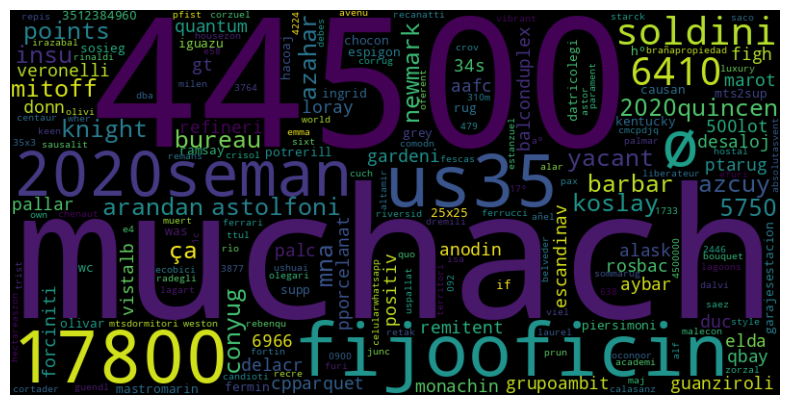

In [33]:
# generate word cloud
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dict(zip(all_vocab, all_idf_scores)))

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


AHAHAHHA it's quite funny :)

We cannot understand and interpret the results as their in Spanish. However, we are going to find the top25 words and translate them manually in English.

In [34]:
# dictionary from vocab and IDF scores
terms_idf = dict(zip(all_vocab, all_idf_scores))

# sort words by IDF scores in descending order
sorted_terms = sorted(terms_idf.items(), key=lambda x: x[1], reverse=True)

# print list
for word, score in sorted_terms[:25]:
    print(f"{word}:{score}")


muchach:9.903145186243169
44500:9.760044342602496
fijooficin:9.63488119964849
us35:9.63488119964849
17800:9.523655564538265
2020seman:9.523655564538265
ø:9.472362270150715
soldini:9.423572105981282
6410:9.377052090346389
2020quincen:9.377052090346389
knight:9.332600327775555
mna:9.332600327775555
insu:9.332600327775555
barbar:9.332600327775555
bureau:9.249218718836506
azcuy:9.209998005683223
azahar:9.209998005683223
ça:9.172257677700376
points:9.172257677700376
5750:9.172257677700376
arandan:9.100798713718232
astolfoni:9.100798713718232
conyug:9.066897162042551
newmark:9.066897162042551
yacant:9.066897162042551


In [35]:
print(sorted_terms[0:25])

[('muchach', 9.903145186243169), ('44500', 9.760044342602496), ('fijooficin', 9.63488119964849), ('us35', 9.63488119964849), ('17800', 9.523655564538265), ('2020seman', 9.523655564538265), ('ø', 9.472362270150715), ('soldini', 9.423572105981282), ('6410', 9.377052090346389), ('2020quincen', 9.377052090346389), ('knight', 9.332600327775555), ('mna', 9.332600327775555), ('insu', 9.332600327775555), ('barbar', 9.332600327775555), ('bureau', 9.249218718836506), ('azcuy', 9.209998005683223), ('azahar', 9.209998005683223), ('ça', 9.172257677700376), ('points', 9.172257677700376), ('5750', 9.172257677700376), ('arandan', 9.100798713718232), ('astolfoni', 9.100798713718232), ('conyug', 9.066897162042551), ('newmark', 9.066897162042551), ('yacant', 9.066897162042551)]


The words are in Spanish and have been stemmed, which means they've been reduced to their base or root form. This can make direct translation a bit challenging without the original context or the full words, but we ll try to provide a general idea of what these words might mean in relation to property or real estate in English:

- muchach: boy
- 44500: address
- fijooficin: fixed office
- us35: likely refers to a pricing in US dollars (USD 35) 
- 17800: address
- 2020seman: "2020 week".
- ø: aspecial character
- soldini: brand - soldini
- 6410: 6410
- 2020quincen: 2020 fortnight
- knight: knight
- mna: abbreviation "morning" 
- insu: insurance
- barbar: great
- bureau: agency
- azcuy: surname
- azahar: orange blossom
- ça: this
- points: points
- 5750: 5750
- arandan: blueberry
- astolfoni: artist
- conyug: spouse
- newmark: real estate services
- yacant: best


In [7]:
# List of lists where each inner list contains a word and its score
words_scores = [
    ["boy", 9.903145186243169],
    ["44500", 9.760044342602496],
    ["fixed office", 9.63488119964849],
    ["USD", 9.63488119964849],
    ["17800", 9.523655564538265],
    ["2020 week", 9.523655564538265],
    ["ø", 9.472362270150715],
    ["soldini", 9.423572105981282],
    ["6410", 9.377052090346389],
    ["2020 fortnight", 9.377052090346389],
    ["knight", 9.332600327775555],
    ["morning", 9.332600327775555],
    ["insurance", 9.332600327775555],
    ["great", 9.332600327775555],
    ["agency", 9.249218718836506],
    ["azcuy", 9.209998005683223],
    ["orange blossom", 9.209998005683223],
    ["this", 9.172257677700376],
    ["points", 9.172257677700376],
    ["5750", 9.172257677700376],
    ["blueberry", 9.100798713718232],
    ["astolfoni", 9.100798713718232],
    ["spouse", 9.066897162042551],
    ["newmark", 9.066897162042551],
    ["best", 9.066897162042551]
]

# Convert to dictionary
word_freq = {item[0]: item[1] for item in words_scores}


Spanish Course aahahhaha

This project is actually getting more interesting with this stuff. No kidding. 

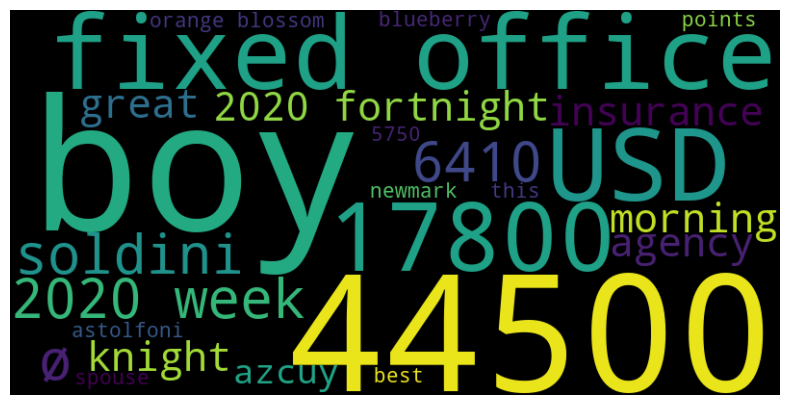

In [8]:
# generate the word cloud in english 
wc = WordCloud(width=800, height=400, max_words=25).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  
plt.show()


The whole dataset word cloud shows a mix of terms related to time ("2020 week", "fortnight"), pricing ("USD", "44500"), and property features or related services ("office", "agency", "points"). The presence of terms like "blueberry" could signify specific features or locations associated with properties.

## Separate Datasets

So now, let's split the dataset to two df (rent and sale), in order to compute the proper features (proper feature engineering) and then move on to the classification tasks.

In [ ]:
# df_nlp.count()

In [36]:
sale_df = df_nlp.filter(col("operation_type")=="Sale")

In [37]:
rent_df = df_nlp.filter(col("operation_type")=="Rent")

In [ ]:
# sale_df.count()

In [ ]:
# rent_df.count()

### Sale Dataset

In [38]:
sale_df = sale_df.repartition(2)

#### TF-IDF

In [39]:
# fit the pipeline model
model_sale = pipeline.fit(sale_df)

# transform the data
df_s = model_sale.transform(sale_df)


In [ ]:
df_s.select("processed_text", "bigrams", "trigrams", "features_unigrams", "features_trigrams", "features","final_features").show()

We save the processed data in Parquet format, which is optimized for big data solutions provided by Apache Spark. This format is chosen for its efficiency in both storage and computation, especially when handling large datasets. This step ensures that we don't need to reprocess data from scratch, which is crucial for large datasets and iterative development processes.

In [40]:
df_s.write.format("parquet").mode("overwrite").save(google_drive_path + "sale_tfidf.parquet")

In [41]:
# extract models from the pipeline stages based on their order in the pipeline configuration
cvModel_unigrams_sale = model_sale.stages[2]  
cvModel_bigrams_sale = model_sale.stages[3]
cvModel_trigrams_sale = model_sale.stages[4]
idfModel_sale = model_sale.stages[-1] 

# vocabulary and IDF scores
vocab_unigrams_sale = cvModel_unigrams_sale.vocabulary
vocab_bigrams_sale = cvModel_bigrams_sale.vocabulary
vocab_trigrams_sale = cvModel_trigrams_sale.vocabulary
idf_scores_sale = idfModel_sale.idf.toArray()


In [42]:

# combine vocab and IDF scores into one list
all_vocab_sale = vocab_unigrams_sale + vocab_bigrams_sale + vocab_trigrams_sale
total_features_sale = len(vocab_unigrams_sale) + len(vocab_bigrams_sale) + len(vocab_trigrams_sale)
all_idf_scores_sale = [float(score) for score in idf_scores_sale[:total_features_sale]]

# df to visualise ngrams and IDF scores
rows_sale = [Row(ngram=ngram, idf_score=float(score)) for ngram, score in zip(all_vocab_sale, all_idf_scores_sale)]
tfidf_df_sale = spark.createDataFrame(rows_sale)

In [43]:
tfidf_df_sale.show(truncate=False, n=15)

+-----------+-------------------+
|ngram      |idf_score          |
+-----------+-------------------+
|dormitori  |0.6338585313854762 |
|bañ        |0.5277760218466712 |
|vent       |0.48537827325086474|
|cocin      |0.5111838348068419 |
|2          |0.8213531749283722 |
|ambient    |0.830386895429505  |
|departament|0.9000780604899802 |
|pis        |0.9826215927480599 |
|comedor    |0.7712750030421238 |
|cas        |1.1495648427452618 |
|3          |1.0858295736956067 |
|ampli      |1.079443004442916  |
|living     |0.8859234027959878 |
|complet    |0.9294244005057666 |
|balcon     |1.2211972478837603 |
+-----------+-------------------+
only showing top 15 rows



#### Wordclouds

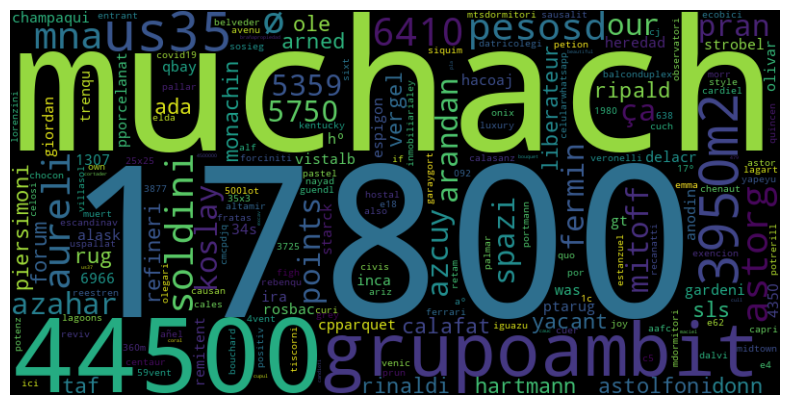

In [44]:
# generate word cloud
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dict(zip(all_vocab_sale, all_idf_scores_sale)))

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [45]:
# dictionary from vocab and IDF scores
terms_idf_sale = dict(zip(all_vocab_sale, all_idf_scores_sale))

# sort words by IDF scores in descending order
sorted_terms_sale = sorted(terms_idf_sale.items(), key=lambda x: x[1], reverse=True)

# print list
for word, score in sorted_terms_sale[:25]:
    print(f"{word}:{score}")


17800:9.771583406655761
muchach:9.691540698982225
44500:9.691540698982225
grupoambit:9.483901334203981
us35:9.423276712387546
3950m2:9.423276712387546
pesosd:9.366118298547597
ø:9.31205107727732
aureli:9.31205107727732
soldini:9.211967618720339
astorg:9.211967618720339
6410:9.165447603085447
mna:9.120995840514611
azahar:9.120995840514611
5750:9.078436226095816
koslay:9.037614231575562
azcuy:8.99839351842228
points:8.99839351842228
fermin:8.99839351842228
our:8.99839351842228
ça:8.960653190439434
pran:8.960653190439434
arandan:8.924285546268559
mitoff:8.924285546268559
spazi:8.924285546268559


In [46]:
print(sorted_terms_sale[0:25])

[('17800', 9.771583406655761), ('muchach', 9.691540698982225), ('44500', 9.691540698982225), ('grupoambit', 9.483901334203981), ('us35', 9.423276712387546), ('3950m2', 9.423276712387546), ('pesosd', 9.366118298547597), ('ø', 9.31205107727732), ('aureli', 9.31205107727732), ('soldini', 9.211967618720339), ('astorg', 9.211967618720339), ('6410', 9.165447603085447), ('mna', 9.120995840514611), ('azahar', 9.120995840514611), ('5750', 9.078436226095816), ('koslay', 9.037614231575562), ('azcuy', 8.99839351842228), ('points', 8.99839351842228), ('fermin', 8.99839351842228), ('our', 8.99839351842228), ('ça', 8.960653190439434), ('pran', 8.960653190439434), ('arandan', 8.924285546268559), ('mitoff', 8.924285546268559), ('spazi', 8.924285546268559)]


By sorting and analyzing the terms based on their IDF scores, we gain insights into which terms are more unique to rental listings compared to those that might be commonly found across sale listings. 

English Translation of the words:


- 17800: location
- muchach: boy
- 44500: location
- grupoambit: company
- us35: usd
- 3950m2: 3950 square meters
- pesosd: pesos - currency
- ø: special character
- aureli: brand
- soldini: brand
- astorg: real estate agency
- 6410: location
- mna: morning
- azahar: orange blossom
- 5750: 5750
- koslay: area
- azcuy: surname
- points: points
- fermin: area - San Fermin
- our: our
- ça: this
- pran: Permanent Retirement Account Number
- arandan: blueberry
- mitoff: historic name
- spazi: spaces - open areas

In [9]:
# List of lists where each inner list contains a word and its score
words_scores = [
    ["17800", 9.771583406655761],
    ["boy", 9.691540698982225],
    ["44500", 9.691540698982225],
    ["Grupo Ambit", 9.483901334203981],
    ["USD", 9.423276712387546],
    ["3950 square meters", 9.423276712387546],
    ["pesos", 9.366118298547597],
    ["ø", 9.31205107727732],
    ["aureli", 9.31205107727732],
    ["soldini", 9.211967618720339],
    ["astorg", 9.211967618720339],
    ["6410", 9.165447603085447],
    ["morning", 9.120995840514611],
    ["orange blossom", 9.120995840514611],
    ["5750", 9.078436226095816],
    ["koslay", 9.037614231575562],
    ["azcuy", 8.99839351842228],
    ["points", 8.99839351842228],
    ["San Fermin", 8.99839351842228],
    ["our", 8.99839351842228],
    ["this", 8.960653190439434],
    ["PRAN", 8.960653190439434],
    ["blueberry", 8.924285546268559],
    ["mitoff", 8.924285546268559],
    ["spaces", 8.924285546268559]
]

# Convert to dictionary
word_freq = {item[0]: item[1] for item in words_scores}


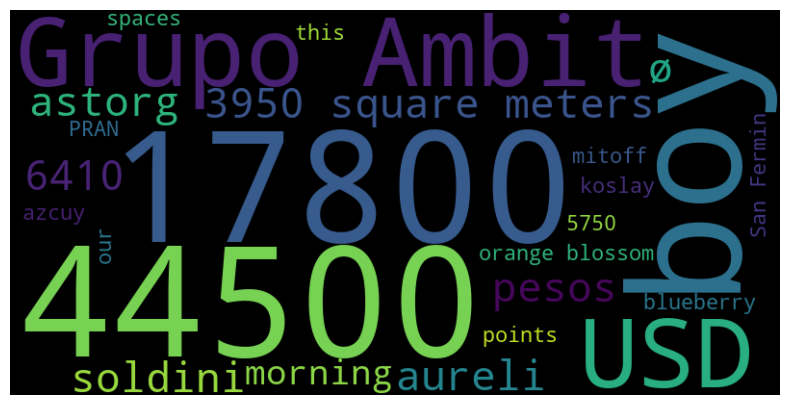

In [10]:
# generate the word cloud in english 
wc = WordCloud(width=800, height=400, max_words=25).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  
plt.show()


This cloud focuses heavily on numerical values ("44500", "square meters") and specific identifiers or brands ("Grupo Ambit", "astorg"), indicating a strong emphasis on property size and relationship with certain developers or organisations eg real estate agencies. The term "USD" underscores the influence of dollar pricing in the sales market.

### Rent Dataset

At the same time, we've implemented a similar text analysis process for the rent dataset as we did for the sale dataset, which is a good practice for maintaining consistency across different segments of our data.

#### TF-IDF

In [47]:
# Fit the pipeline model
model_rent = pipeline.fit(rent_df)

# Transform the data
df_r = model_rent.transform(rent_df)


In [ ]:
df_r.select("processed_text", "bigrams", "trigrams", "features_unigrams", "features_trigrams", "features", "final_features").show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      processed_text|             bigrams|            trigrams|   features_unigrams|   features_trigrams|            features|      final_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|[alquil, salvador...|[alquil salvador,...|[alquil salvador ...|(10000,[0,1,5,6,9...|(2000,[112,226,39...|(17000,[0,1,5,6,9...|(17000,[0,1,5,6,9...|
|[torr, bellini, 3...|[torr bellini, be...|[torr bellini 3, ...|(10000,[0,5,6,9,1...|(2000,[536,843,95...|(17000,[0,5,6,9,1...|(17000,[0,5,6,9,1...|
|[torr, bellini, 4...|[torr bellini, be...|[torr bellini 4, ...|(10000,[0,5,6,9,1...|(2000,[536,843,95...|(17000,[0,5,6,9,1...|(17000,[0,5,6,9,1...|
|[ortiz, ocamp, gr...|[ortiz ocamp, oca...|[ortiz ocamp gral...|(10000,[6,20,22,2...|(2000,[307,416],[...|

In [48]:
df_r.write.format("parquet").mode("overwrite").save(google_drive_path + "rent_tfidf.parquet")

In [49]:

cvModel_unigrams_rent = model_rent.stages[2]  
cvModel_bigrams_rent = model_rent.stages[3]
cvModel_trigrams_rent = model_rent.stages[4]
idfModel_rent = model_rent.stages[-1]  

# vocabulary and IDF scores
vocab_unigrams_rent = cvModel_unigrams_rent.vocabulary
vocab_bigrams_rent = cvModel_bigrams_rent.vocabulary
vocab_trigrams_rent = cvModel_trigrams_rent.vocabulary
idf_scores_rent = idfModel_rent.idf.toArray()


In [50]:

# combine vocab and IDF scores
all_vocab_rent = vocab_unigrams_rent + vocab_bigrams_rent + vocab_trigrams_rent
total_features_rent = len(vocab_unigrams_rent) + len(vocab_bigrams_rent) + len(vocab_trigrams_rent)
all_idf_scores_rent = [float(score) for score in idf_scores_rent[:total_features_rent]]

# df
rows_rent = [Row(ngram=ngram, idf_score=float(score)) for ngram, score in zip(all_vocab_rent, all_idf_scores_rent)]
tfidf_df_rent = spark.createDataFrame(rows_rent)

In [51]:
tfidf_df_rent.show(truncate=False, n=15)

+-----------+-------------------+
|ngram      |idf_score          |
+-----------+-------------------+
|alquil     |0.3197557686376437 |
|bañ        |0.43387579018823985|
|departament|0.7639428808121924 |
|dormitori  |0.7049984495916183 |
|cocin      |0.5278481771509047 |
|2          |0.8588157563951914 |
|pis        |1.0335002483444673 |
|ambient    |0.9425555904877564 |
|comedor    |0.8428962912632131 |
|complet    |0.9727255352222064 |
|1          |1.3008442857112676 |
|3          |1.2686234067001048 |
|cas        |1.4513467658700991 |
|balcon     |1.2044436299609997 |
|ampli      |1.230824628860576  |
+-----------+-------------------+
only showing top 15 rows



#### Wordclouds

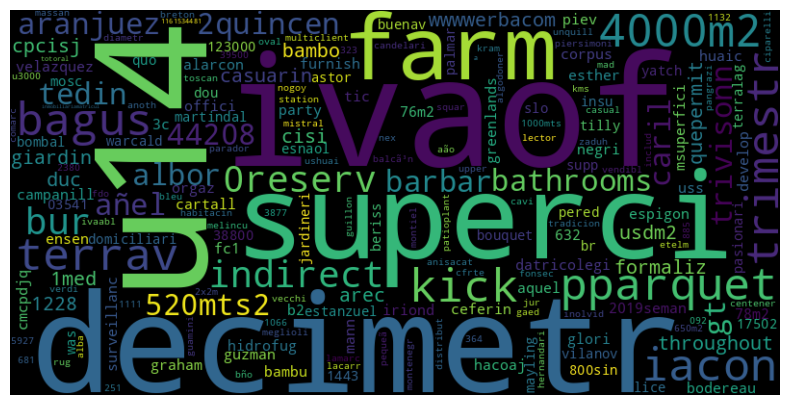

In [52]:
# generate word cloud
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(dict(zip(all_vocab_rent, all_idf_scores_rent)))

# plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [53]:
# dictionary from vocab and IDF scores
terms_idf_rent = dict(zip(all_vocab_rent, all_idf_scores_rent))

# sort words by IDF scores in descending order
sorted_terms_rent = sorted(terms_idf_rent.items(), key=lambda x: x[1], reverse=True)

# print list
for word, score in sorted_terms_rent[:25]:
    print(f"{word}:{score}")


u14:9.71252880234651
ivaof:9.424846729894728
decimetr:9.424846729894728
superci:9.20170317858052
farm:9.20170317858052
pparquet:9.20170317858052
4000m2:9.20170317858052
bagus:9.019381621786565
kick:9.019381621786565
terrav:9.019381621786565
iacon:9.019381621786565
trimestr:9.019381621786565
indirect:9.019381621786565
0reserv:9.019381621786565
bur:9.019381621786565
2quincen:9.019381621786565
520mts2:9.019381621786565
gt:8.865230941959306
caril:8.865230941959306
añel:8.865230941959306
aranjuez:8.865230941959306
barbar:8.865230941959306
bathrooms:8.865230941959306
trivisonn:8.865230941959306
44208:8.865230941959306


In [54]:
print(sorted_terms_rent[0:25])

[('u14', 9.71252880234651), ('ivaof', 9.424846729894728), ('decimetr', 9.424846729894728), ('superci', 9.20170317858052), ('farm', 9.20170317858052), ('pparquet', 9.20170317858052), ('4000m2', 9.20170317858052), ('bagus', 9.019381621786565), ('kick', 9.019381621786565), ('terrav', 9.019381621786565), ('iacon', 9.019381621786565), ('trimestr', 9.019381621786565), ('indirect', 9.019381621786565), ('0reserv', 9.019381621786565), ('bur', 9.019381621786565), ('2quincen', 9.019381621786565), ('520mts2', 9.019381621786565), ('gt', 8.865230941959306), ('caril', 8.865230941959306), ('añel', 8.865230941959306), ('aranjuez', 8.865230941959306), ('barbar', 8.865230941959306), ('bathrooms', 8.865230941959306), ('trivisonn', 8.865230941959306), ('44208', 8.865230941959306)]


English Translation:


u14: address code
ivaof: VAT
decimetr: decimeter
superci: Super Cup
farm: farm - rural property
pparquet: parquet - floor
4000m2: 4000 square meters
bagus: high quality
kick: kick
terrav: terrace
iacon: brand
trimestr: quarter - for payment
indirect: indirect
0reserv: reservation
bur: Biennial update reports
2quincen: fortnight
520mts2: 520 square meters
gt: greater
caril: Carilo - Beach Resort
añel: ?
aranjuez: historical city in Spain
barbar: greate
bathrooms: bathrooms
trivisonn: trivisonn
44208: 44208

In [11]:
# List of lists where each inner list contains a word and its score
words_scores = [
    ["u14", 9.71252880234651],
    ["VAT", 9.424846729894728],
    ["decimeter", 9.424846729894728],
    ["Super Cup", 9.20170317858052],
    ["farm", 9.20170317858052],
    ["parquet", 9.20170317858052],
    ["4000 square meters", 9.20170317858052],
    ["high quality", 9.019381621786565],
    ["kick", 9.019381621786565],
    ["terrace", 9.019381621786565],
    ["iacon", 9.019381621786565],
    ["quarter", 9.019381621786565],
    ["indirect", 9.019381621786565],
    ["reservations", 9.019381621786565],
    ["BUR", 9.019381621786565],
    ["fortnight", 9.019381621786565],
    ["520 square meters", 9.019381621786565],
    ["greater", 8.865230941959306],
    ["Carilo", 8.865230941959306],
    ["añel", 8.865230941959306],
    ["Aranjuez", 8.865230941959306],
    ["great", 8.865230941959306],
    ["bathrooms", 8.865230941959306],
    ["trivisonn", 8.865230941959306],
    ["44208", 8.865230941959306]
]

# Convert to dictionary
word_freq = {item[0]: item[1] for item in words_scores}


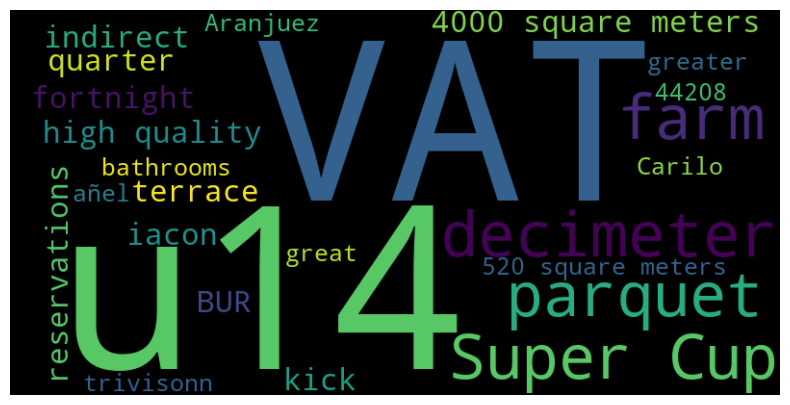

In [12]:
# generate the word cloud in english 
wc = WordCloud(width=800, height=400, max_words=25).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  
plt.show()


The rent properties word cloud leans more towards terms associated with rental conditions and property features ("VAT", "terraces", "high quality"). "Indirect" and "reservations" suggest a focus on booking or leasing processes, while "quarter" and "520 square meters" reflect rental periods and property size specifics.

**Comparative Analysis**

- **Common Themes:** Both the "sale" and "rent" clouds include terms related to property sizes and values, indicative of their universal importance in real estate listings. However, the specific terms differ, reflecting tailored focuses in each market.

- **Unique to Sale:** Terms like "Grupo Ambit" and specific numerical values suggest a market that values brand recognition and detailed property specifications. The usage of "USD" highlights the international appeal or transactions in the sales market. This makes actually sense, when it comes to buying a property.

- **Unique to Rent:** More emphasis on leasing conditions ("VAT", "indirect", "reservations") and features enhancing living quality ("high quality", "terraces") suggest that rental properties focus on amenities and leasing terms that appeal to temporary residents or those seeking flexible living arrangements.

- **Time-Related Terms:** The appearance of "2020 week" in the whole dataset and "quarter" in the rent dataset underscores the importance of time frames in property listings, which can be crucial for understanding market dynamics and consumer behavior in real estate.


**Overall Conclusions**

The analysis of word clouds across different segments of the real estate market in Argentina shows distinct priorities and focuses:

**Sales market:** More focused on property specifications, brand associations, and investment details, attracting buyers interested in detailed aspects of property and investment potential.

**Rental market:** Centers around rental terms, property amenities, and features that contribute to the quality of living, covering to renters’ immediate living needs and convenience.

## Clustering

Latent Dirichlet Allocation (LDA) is utilized to find latent topics in our real estate datasets, distinguishing between properties for sale and rent. Each topic is represented as a mix of words, each contributing with a certain weight.
- The LDA model is initialized with specific parameters (k for the number of topics and maxIter for the maximum iterations) and fitted to the data. 
- The model transforms our TF-IDF vectors to identify latent topics within the datasets. 
- Topics are extracted and visualized using word clouds to represent the weight of each term visually. This aids in intuitively understanding the thematic focus of different segments within the data.

Benefits of this Approach

- Enhancing Understanding: Providing deeper insights into the content covered in property descriptions.
- Improving Feature Engineering: Guiding further refinement of features for machine learning tasks based on identified topics.

In [56]:
# initialize the LDA model with specified parameters
lda = LDA(featuresCol="final_features", k=10, maxIter=50)


In [57]:
# fit the model on sale data
lda_model_sale = lda.fit(df_s)
# transform the data
lda_result_sale = lda_model_sale.transform(df_s)

In [58]:
print("--- Sale Dataset with LDA results ---")
lda_result_sale.show()

--- Sale Dataset with LDA results ---
+----------+----------+--------------------+----------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|start_date|  end_date|                  l2|              l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|amount_in_euro|    full_description|      processed_text|             bigrams|            trigrams|   features_unigrams|    features_bigrams|   features_trigrams|            features|      final_features|   topicDistribution|
+----------+----------+--------------------+----------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+------------

In [59]:

# fit the model on rental data
lda_model_rent = lda.fit(df_r)
# transform the data
lda_result_rent = lda_model_rent.transform(df_r)

In [60]:
print("--- Rent Dataset with LDA results ---")
lda_result_rent.show()

--- Rent Dataset with LDA results ---
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|    amount_in_euro|    full_description|      processed_text|             bigrams|            trigrams|   features_unigrams|    features_bigrams|   features_trigrams|            features|      final_features|   topicDistribution|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+-------------------

In [61]:
# get the topics represented as word weights
topics_sale = lda_model_sale.describeTopics(maxTermsPerTopic=10)
topics_rent = lda_model_rent.describeTopics(maxTermsPerTopic=10)

In [65]:
def extract_terms(topics_df, vocab):
    topics = topics_df.collect()  # collect once and iterate locally
    terms = []
    for idx, topic in enumerate(topics):
        # print("Topic ID: " + str(idx))
        term_indices = topic['termIndices']
        term_weights = topic['termWeights']
        terms_dict = {vocab[i]: weight for i, weight in zip(term_indices, term_weights)} # map indices to terms and weights using the vocabulary
        terms.append((idx, terms_dict))  # append topic_id in the tuple
    return terms


In [66]:

# extract terms for both sales and rental datasets through the above function
terms_sale = extract_terms(topics_sale, cvModel_unigrams.vocabulary + cvModel_bigrams.vocabulary + cvModel_trigrams.vocabulary)
terms_rent = extract_terms(topics_rent, cvModel_unigrams.vocabulary + cvModel_bigrams.vocabulary + cvModel_trigrams.vocabulary)


Generating word cloud for Sales Topic ID: 0


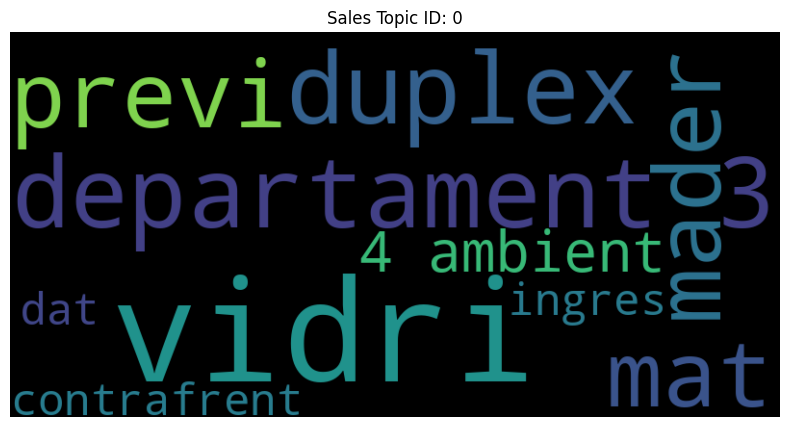

Generating word cloud for Sales Topic ID: 1


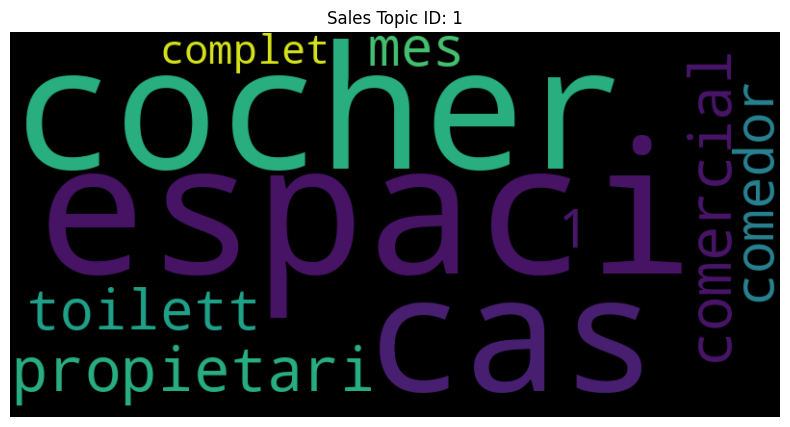

Generating word cloud for Sales Topic ID: 2


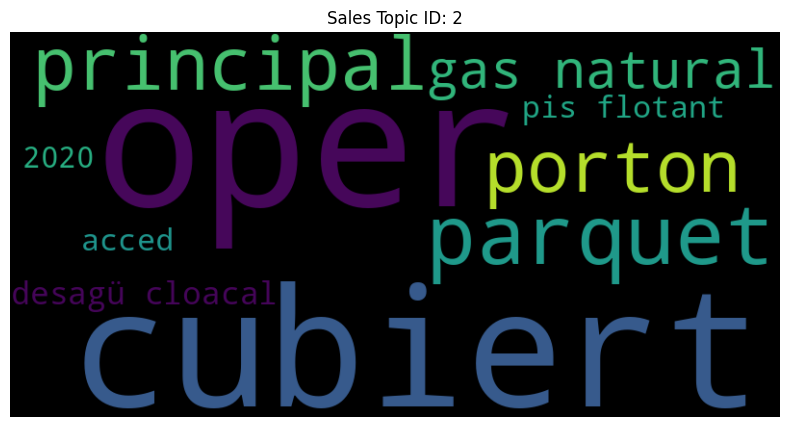

Generating word cloud for Sales Topic ID: 3


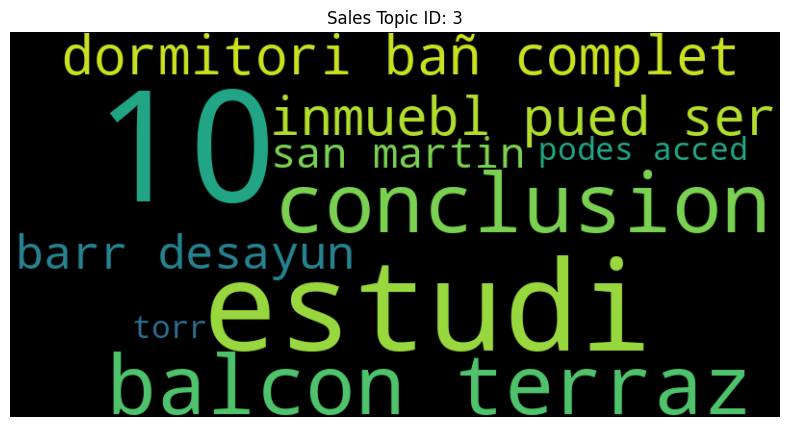

Generating word cloud for Sales Topic ID: 4


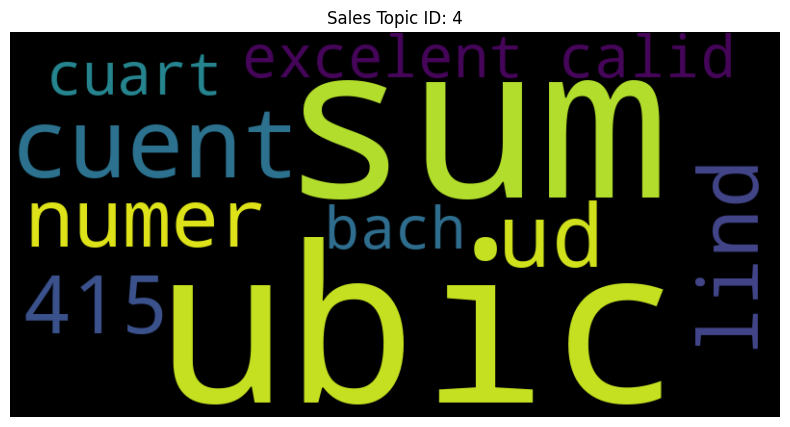

Generating word cloud for Sales Topic ID: 5


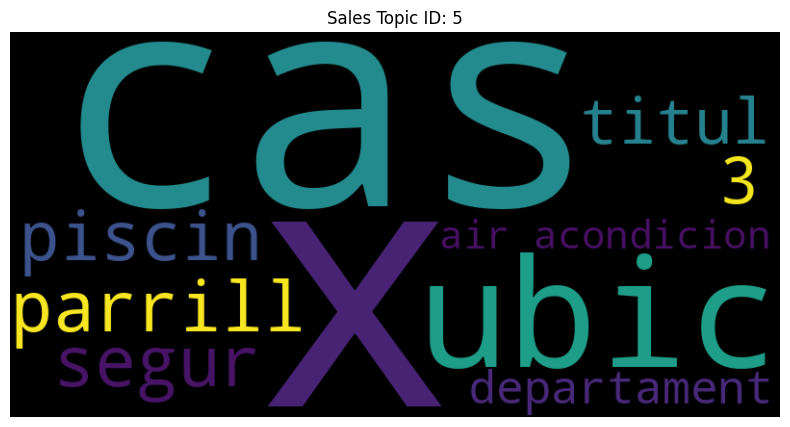

Generating word cloud for Sales Topic ID: 6


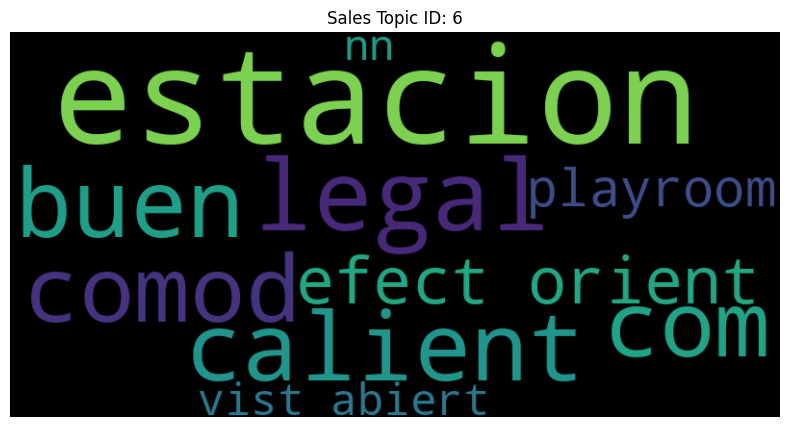

Generating word cloud for Sales Topic ID: 7


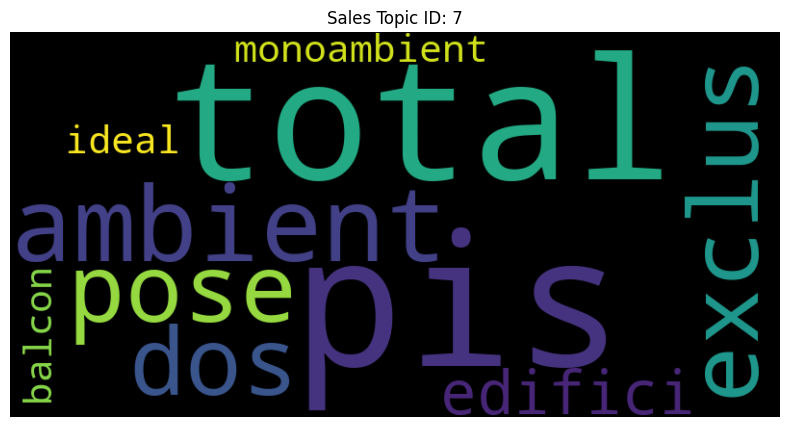

Generating word cloud for Sales Topic ID: 8


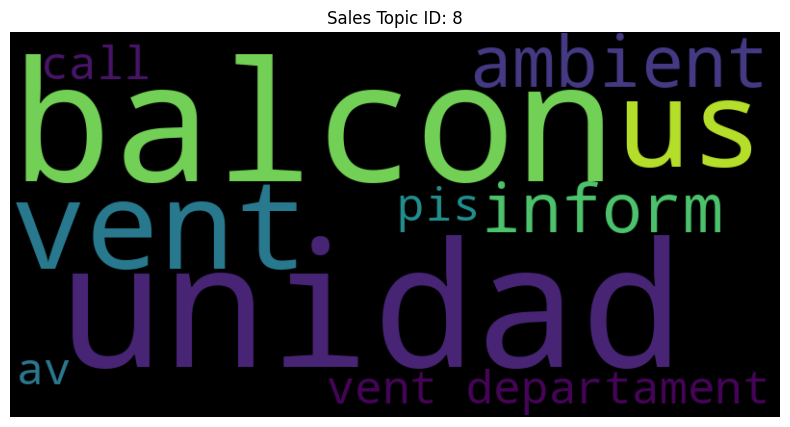

Generating word cloud for Sales Topic ID: 9


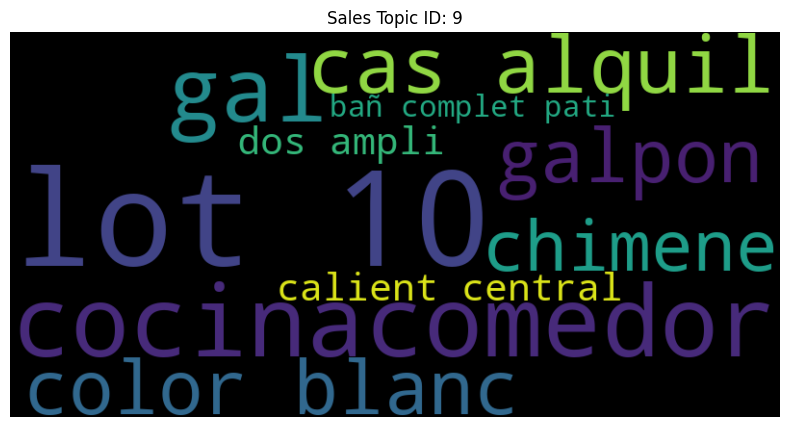

In [67]:
# visualize topics for sales dataset
for topic_id, terms_dict in terms_sale:
    print(f"Generating word cloud for Sales Topic ID: {topic_id}")
    wc = WordCloud(width=800, height=400, max_words=10).generate_from_frequencies(terms_dict)  # Limiting to top 10 terms for clarity
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Sales Topic ID: {topic_id}")
    plt.show()

Generating word cloud for Rental Topic ID: 0


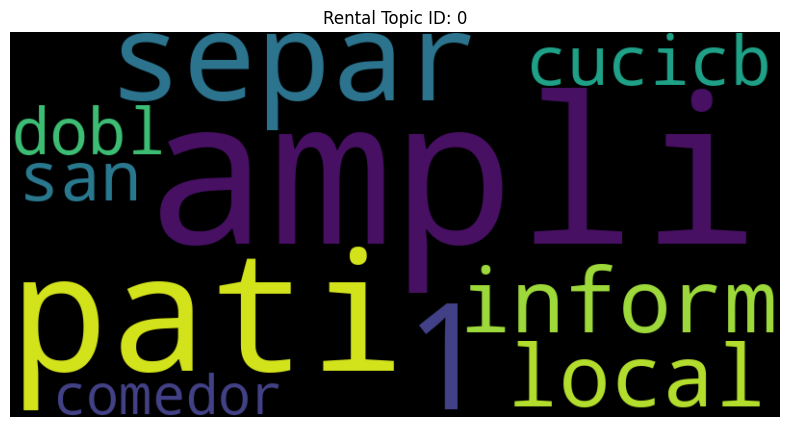

Generating word cloud for Rental Topic ID: 1


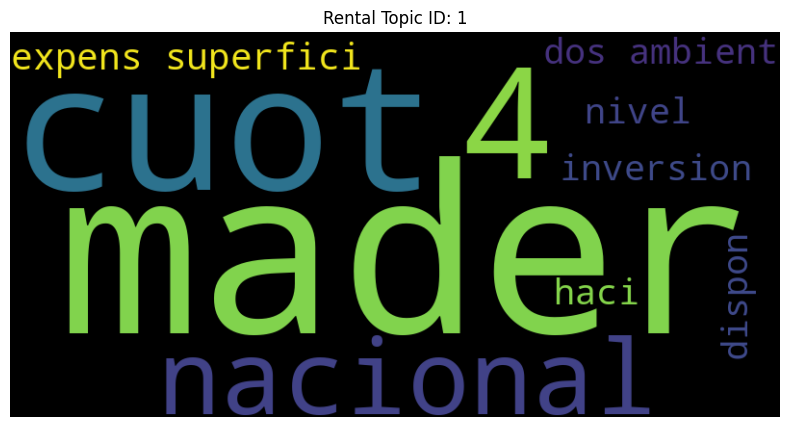

Generating word cloud for Rental Topic ID: 2


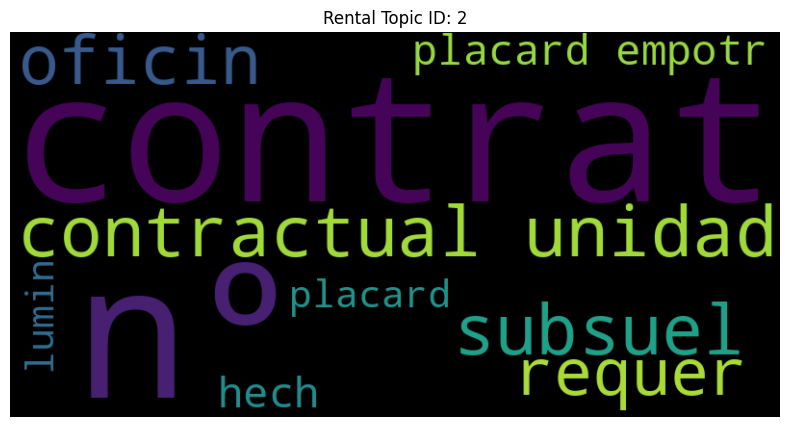

Generating word cloud for Rental Topic ID: 3


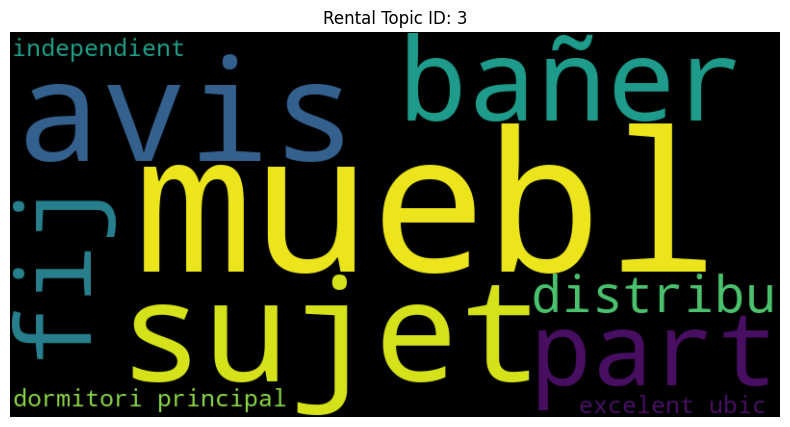

Generating word cloud for Rental Topic ID: 4


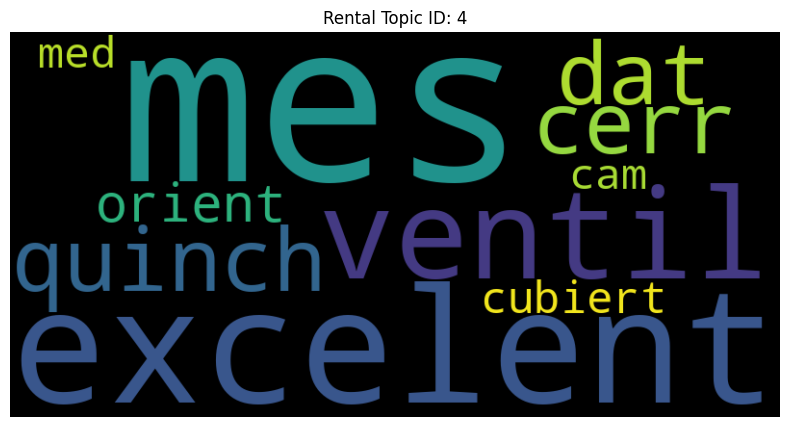

Generating word cloud for Rental Topic ID: 5


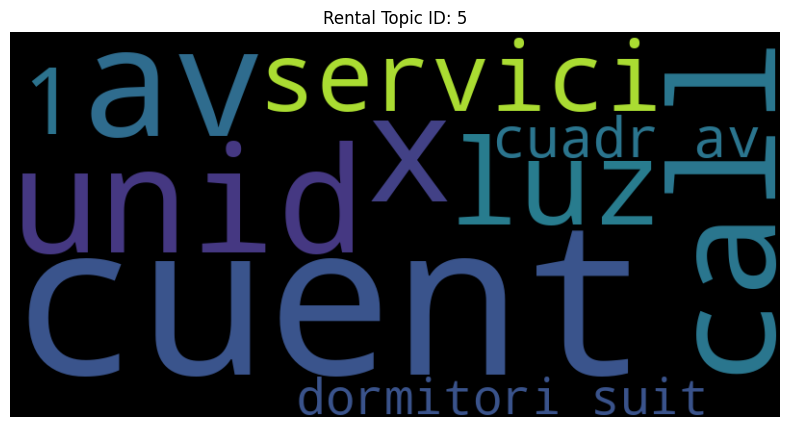

Generating word cloud for Rental Topic ID: 6


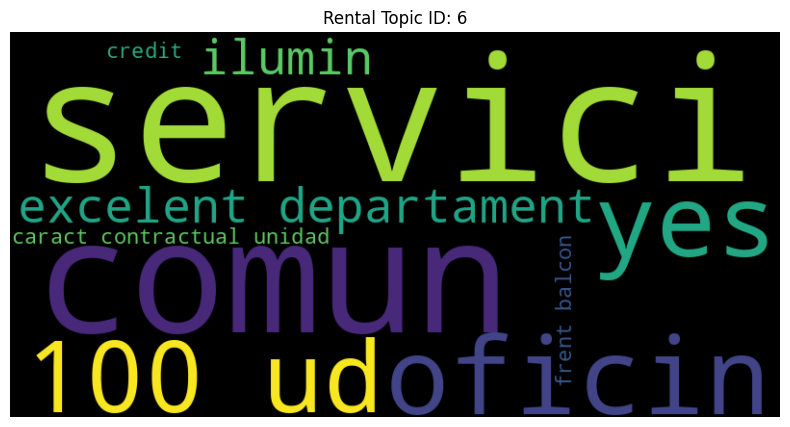

Generating word cloud for Rental Topic ID: 7


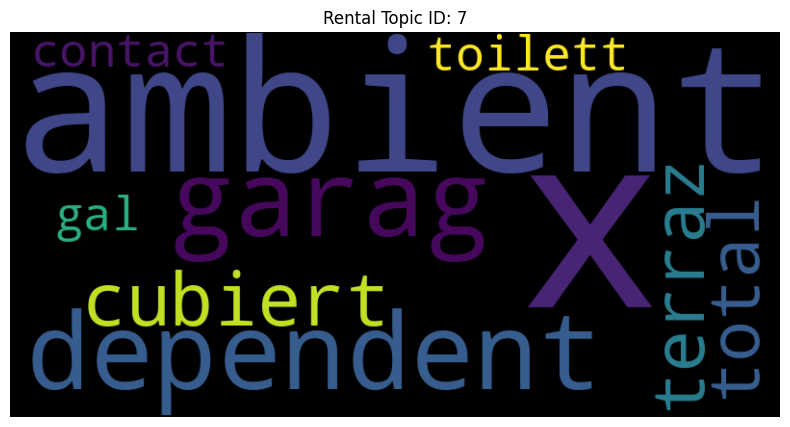

Generating word cloud for Rental Topic ID: 8


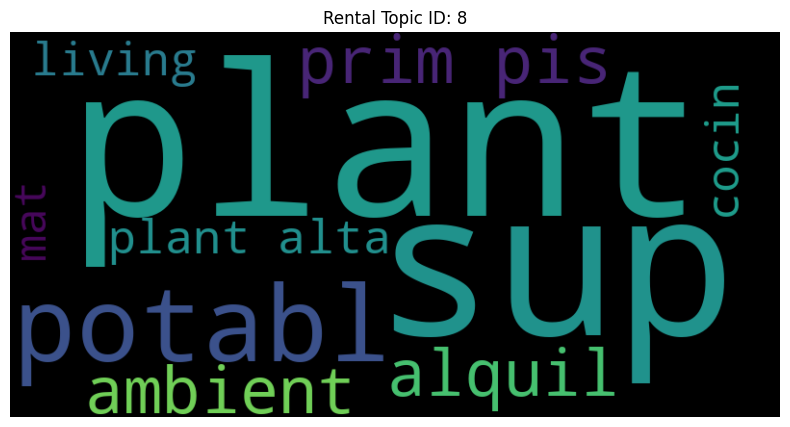

Generating word cloud for Rental Topic ID: 9


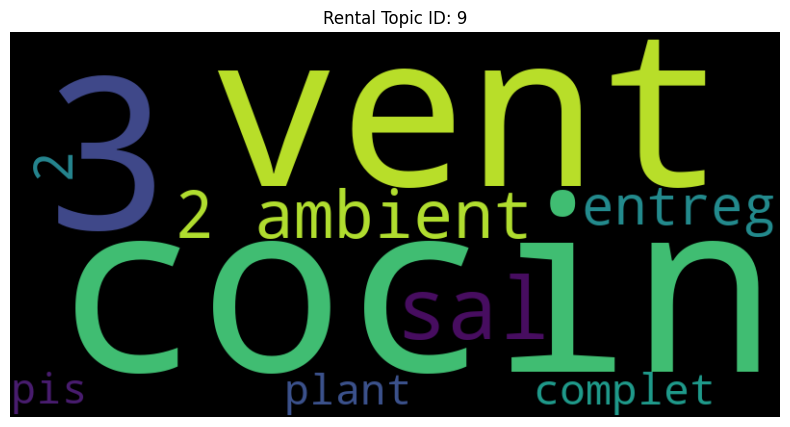

In [68]:
# visualize topics for rent dataset
for topic_id, terms_dict in terms_rent:
    print(f"Generating word cloud for Rental Topic ID: {topic_id}")
    wc = WordCloud(width=800, height=400, max_words=10).generate_from_frequencies(terms_dict)  # Limiting to top 10 terms for clarity
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Rental Topic ID: {topic_id}")
    plt.show()

### Interpretation

From the provided word clouds representing different topics within sales and rent properties' descriptions, we will select two clusters from each category, where the relationship among the words seems coherent and meaningful within the context of property sales. We'll then translate the words, analyze, and interpret the topics. We cannnot understand fully the meanings of the words but we will do our best in interpreting in the most appropriate way the results.

#### Sale Clusters

**Sales Topic 0**

Words: "previ", "duplex", "departamento", "4", "ambientes", "vidri", "ingres", "mat", "contrafrent".

Translation:

- previ:?
- duplex: type of house
- departamento: apartment
- ambientes: rooms
- vidri: windows
- ingres: entrance
- mat: license
- contrafrent: contract

**Sales Topic 1**

Words: "cocher", "espaci", "complet", "mes", "toilett", "propietari", "comercial", "comedor".


Translation:


- cocher: garage
- espaci: space
- complet: complete
- mes: month
- toilett: toilet
- propietari: owner
- comercial: commercial
- comedor: dining room

**Sales - Topic Number 0**

This word cloud seems to center around the features and specifications of an apartment unit. The reference to "4 rooms" suggests a fairly spacious apartment, suitable for families or residents needing multiple living spaces. The mention of "glass" and "entrance" could indicate detailed descriptions of the apartment's aesthetics and entry points, while "contract" implies that these listings may also focus on the legal aspects or terms of sale. 

**Sales - Topic Number 1**

This cluster appears to be oriented towards commercial property listings or apartments with specific amenities. The terms "garage" and "commercial" highlight properties suitable for business use or those with adequate parking facilities, which are valuable in urban environments. "Complete", "month", and "dining room" suggest listings that are ready for immediate occupation and might be available for short-term leases or monthly rentals. The mention of "owner" might indicate direct dealings with property owners rather than through agents, offering a more personal transaction process.

#### Rent Clusters

**Rental Topic 0**


Words: "separ", "cucicb", "dobl", "san", "ampli", "pati", "inform", "local", "comedor".


Translation:


- separ: separated
- bcucicb: ?
- dobl: double
- san: sanitary
- ampli: spacious
- pati: patio
- inform: information
- local: local
- comedor: dining room

**Rental Topic 1**


Words: "expens", "superfici", "dos ambient", "cuot", "4", "mader", "nacional".


Translation:


- expens: expenses
- superfici: surface
- dos ambient: two rooms
- cuot: installment
- 4: 4
- mader: wood
- nacional: national

**Rental Topic Number 0**

This cluster appears to focus on the physical and functional aspects of rental properties. The terms suggest a rental property with a patio, which is spacious and possibly features double or separated amenities. The mention of "local" and "comedor" indicates that the properties might be suitable for both living and commercial purposes, such as a restaurant or a store with a dining area. This cluster emphasizes properties that offer versatile living spaces, which can be attractive in urban environments where flexible use spaces are valued.

**Rental Topic Number 1**

The focus here seems to be on financial aspects and property features. "Expenses" and "installment" suggest that the rental terms include particular payment conditions or fees, which are important for tenants to know upfront. "Two rooms" and "surface" refer to the size and layout of the property, while "wood" and "national" might hint at local construction materials or styles, promoting properties built with national or traditional techniques and materials. This cluster likely appeals to tenants interested in budgeting details and the aesthetic or ecological qualities of their living space.



Just for check, to see that everything was saved as it should be.

In [69]:
df1 = spark.read.format("parquet").load(google_drive_path + "sale_tfidf.parquet")

In [70]:
df1.show()

+----------+----------+--------------------+----------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|start_date|  end_date|                  l2|              l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|amount_in_euro|    full_description|      processed_text|             bigrams|            trigrams|   features_unigrams|    features_bigrams|   features_trigrams|            features|      final_features|
+----------+----------+--------------------+----------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+--------------+--------------------+--------------------+--------------------+--------------

In [71]:
df2 = spark.read.format("parquet").load(google_drive_path + "rent_tfidf.parquet")

In [72]:
df2.show()

+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|start_date|  end_date|                  l2|                l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|property_type|operation_type|         coordinates|    amount_in_euro|    full_description|      processed_text|             bigrams|            trigrams|   features_unigrams|    features_bigrams|   features_trigrams|            features|      final_features|
+----------+----------+--------------------+------------------+-----+--------+---------+-------------+---------------+-------------+--------------+--------------------+------------------+--------------------+--------------------+-----------------